In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import pandas as pd

dataPath = '/content/drive/MyDrive/Partage Full CloudiAtlas/Cloud_iAtlas'
df = pd.read_csv(dataPath+'/train_enriched.csv')

In [ ]:
# ATTENTION x_c et y_c ont été inversé

In [6]:
x = 2100
y = 1400

df['x1'] = df['ymin']/x       # ATTENTION xmin et ymin ont été inversé
df['x2'] = df['ymax']/x       # ATTENTION xmax et ymax ont été inversé
df['xmoy'] = df['y_c']/x      # ATTENTION x_c et y_c ont été inversé
df['width'] = df['width']/x

df['y1'] = df['xmin']/y       # ATTENTION xmin et ymin ont été inversé
df['y2'] = df['xmax']/y       # ATTENTION xmax et ymax ont été inversé
df['ymoy'] = df['x_c']/y      # ATTENTION x_c et y_c ont été inversé
df['height'] = df['height']/y

df = df.drop(['x_c', 'y_c', 'xmin', 'xmax', 'ymin', 'ymax'], axis = 1)

df['file_name'] = df['Image_Label'].apply(lambda x: x.split("_")[0])
df['cloud_class'] = df['Image_Label'].apply(lambda x: x.split("_")[1])

# df['has_class'] = df['EncodedPixels'].isnull()
df['has_class'] = df['EncodedPixels'].apply(lambda x: 0 if x == -1 else 1)

df2 = pd.read_csv(dataPath+'/cloud_class.csv')
df2 = df2[df2['nb_class']==1]

df = df[df['ratio']>0.80]
print(df.shape)

# Rassembler les dataFrames df et df2
masque = df['file_name'].isin(df2['file_name'])
df = df[masque]
print(df.shape)

one_hot_encoded = pd.get_dummies(df['cloud_class'])
df = pd.concat([df, one_hot_encoded], axis=1)

df = df.reset_index(drop=True)

df.head()

(8441, 14)
(998, 14)


,Image_Label,EncodedPixels,ratio,height,width,x1,x2,xmoy,y1,y2,ymoy,file_name,cloud_class,has_class,Fish,Flower,Gravel,Sugar
0,008233e.jpg_Sugar,910449 829 911849 829 913249 829 914649 829 91...,0.971020,0.651429,0.509524,0.309524,0.818571,0.564048,0.260714,0.911429,0.586071,008233e.jpg,Sugar,1,0,0,0,1
1,0095357.jpg_Sugar,1757754 373 1759154 373 1760554 373 1761954 37...,1.000000,0.266429,0.243333,0.597619,0.840476,0.719048,0.537857,0.803571,0.670714,0095357.jpg,Sugar,1,0,0,0,1
2,00d4443.jpg_Sugar,70287 806 71687 806 73087 806 74487 806 75887 ...,0.832580,0.575714,0.849048,0.023810,0.872381,0.448095,0.204286,0.779286,0.491786,00d4443.jpg,Sugar,1,0,0,0,1
3,0146ef3.jpg_Fish,274423 1263 275823 1263 277223 1263 278623 126...,1.000000,0.902143,0.740476,0.093333,0.833333,0.463333,0.015714,0.917143,0.466429,0146ef3.jpg,Fish,1,1,0,0,0
4,01c6ec3.jpg_Flower,18216 1074 19616 1074 21016 1074 22416 1074 23...,0.900545,0.767143,0.980952,0.006190,0.986667,0.496429,0.010714,0.777143,0.393929,01c6ec3.jpg,Flower,1,0,1,0,0


In [7]:
"""
df = df.drop(['EncodedPixels'], axis = 1)
df.to_csv('/content/drive/My Drive/Partage Full CloudiAtlas/Cloud_iAtlas/trainForPred.csv', sep = ';', index = False)
"""

In [ ]:
# Distribution des variables cibles
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
folder_images = '/content/drive/MyDrive/Partage Full CloudiAtlas/Outputs/train_images_525-350_gray/'


/content/drive/MyDrive/Partage Full CloudiAtlas/Outputs/train_images_525-350_gray/0d6d044.jpg
(350, 525, 1)


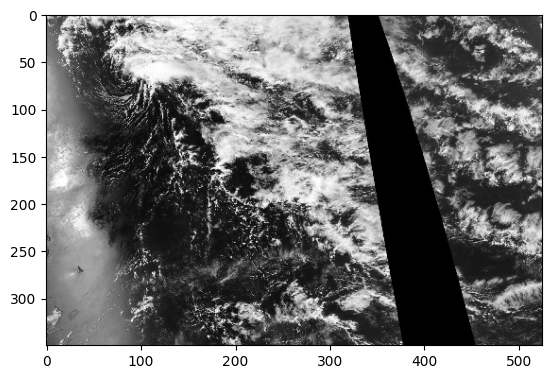

In [ ]:
def load_image(filepath, resize=None):
    im = tf.io.read_file(folder_images + filepath)
    im = tf.image.decode_png(im, channels=1)
    #im = tf.image.resize(im, size=(256,256)) #Test_24
    #im = np.repeat(im, 3, axis=2) # TO DELETE, UNIQUEMENT POUR LE EFFICIENTNET
    if resize:
        return tf.image.resize(im, resize)
    else :
        return im

print(folder_images + df.file_name[35])
im = load_image(df.file_name[35])
print(im.shape)
plt.imshow(im, cmap='gray');

In [ ]:
import numpy as np

def show_bounding_box(im, bbox, normalised=True, color='r', text = None):
    # Signification de bbox
    x, y, w, h = bbox
    # Convertir les cordonées (x,y,w,h) en (x1,x2,y1,y2)
    x1=x-w/2
    x2=x+w/2
    y1=y-h/2
    y2=y+h/2

    # Redimensionner en cas de normalisation
    if normalised:
        x1=x1*im.shape[1]
        x2=x2*im.shape[1]
        y1=y1*im.shape[0]
        y2=y2*im.shape[0]

    # Afficher l'image
    plt.imshow(im, cmap='gray')
    plt.text(x1+8, y1+16, text, color='white', fontsize=8, bbox=dict(facecolor=color, alpha=0.6))

    # Afficher la bounding box
    plt.plot([x1,x2,x2,x1,x1],[y1,y1,y2,y2,y1],color)

def show_bounding_box2(im, bbox, normalised=True, color='r', text = None):
    # Signification de bbox
    x1, x2, y1, y2 = bbox

    # Redimensionner en cas de normalisation
    if normalised:
        x1=x1*im.shape[1]
        x2=x2*im.shape[1]
        y1=y1*im.shape[0]
        y2=y2*im.shape[0]

    # Afficher l'image
    plt.imshow(im, cmap='gray')
    plt.text(x1+10, y1+10, text, color='white', fontsize=8, bbox=dict(facecolor=color, alpha=0.6))
    # Afficher la bounding box
    plt.plot([x1,x2,x2,x1,x1],[y1,y1,y2,y2,y1],"r")

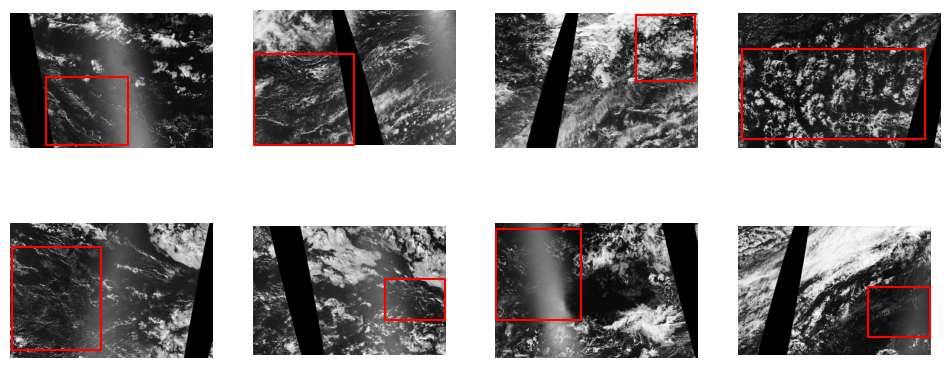

In [ ]:
plt.figure(figsize=(12,5))
for j, i in enumerate(np.random.randint(0, len(df), size=[8])):
    plt.subplot(2,4,j+1)
    plt.axis('off')
    im = load_image(df.file_name[i])
    bbox = df[['xmoy', 'ymoy', 'width', 'height']].values[i]
    show_bounding_box(im, bbox, normalised=True)

In [ ]:
## Insérez votre code ici

from tensorflow.keras.optimizers import SGD, Adam, RMSprop


def loss_function(y_true, y_pred):
    e1 = tf.abs(y_true[:,0] - y_pred[:,0])
    e2 = tf.abs(y_true[:,1] - y_pred[:,1])
    e3 = (tf.sqrt(tf.abs(y_pred[:,2])) - tf.sqrt(y_true[:,2]))**2
    e4 = (tf.sqrt(tf.abs(y_pred[:,3])) - tf.sqrt(y_true[:,3]))**2
    s = e1 + e2 + e3 + e4
    loss = tf.reduce_sum(s) / 32
    return loss


def loss_function2(y_true, y_pred):
  yClass_true = y_true[:,4:8]
  yClass_pred = y_pred
  return tf.keras.losses.categorical_crossentropy(yClass_true, yClass_pred)


In [ ]:
from tensorflow.keras.utils import custom_object_scope

# Définissez une fonction pour charger le modèle en utilisant le custom_object_scope
def load_model_with_custom_objects(model_path):
    with custom_object_scope({'loss_function': loss_function}):
        modele_charge = tf.keras.models.load_model(model_path)
    return modele_charge

def load_model_with_custom_objects2(model_path):
    with custom_object_scope({'loss_function': loss_function2}):
        modele_charge = tf.keras.models.load_model(model_path)
    return modele_charge

# Chargez le modèle en utilisant la fonction définie
model_reg = load_model_with_custom_objects('/content/drive/MyDrive/Partage Full CloudiAtlas/Cloud_iAtlas/first_model_test.h5')

# Chargez le modèle en utilisant la fonction définie
model_class = load_model_with_custom_objects2('/content/drive/MyDrive/Partage Full CloudiAtlas/Cloud_iAtlas/first_model_avecClassification.h5')

# model = tf.keras.models.load_model('/content/drive/MyDrive/Partage Full CloudiAtlas/Cloud_iAtlas/first_model.h5')


In [ ]:
"""
import time
def show_img(img, model):
  plt.imshow(img)
  t0=time.time()
  x, y, w, h = model.predict(np.array([img], dtype=np.float32))[0]
  print(x, y, w, h)
  print("Execution time :",time.time()-t0,"secondes")
  show_bounding_box(img/255, [x,y,w,h])
  plt.show()

def show_img2(img, model,y_true):
  print(y_true[0], y_true[1], y_true[2], y_true[3])
  plt.imshow(img)
  t0=time.time()
  x, y, w, h = model.predict(np.array([img], dtype=np.float32))[0]
  print(x, y, w, h)
  print("Execution time :",time.time()-t0,"secondes")
  show_bounding_box(img/255, [x,y,w,h])
  show_bounding_box(img/255, [y_true[0], y_true[1], y_true[2], y_true[3]], color = 'g')
  plt.show()
## Exemple :
# show_img(load_image(X_train_path[10]).numpy().astype(np.uint8), model)
sample = 17
show_img2(X_test[sample], model, y_test.iloc[sample])
"""

In [ ]:
# ['Fish', 'Flower', 'Gravel', 'Sugar']
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score


def print_class(img, model, y_true):
  print("CLASS REELLE :")
  print('Fish', y_true[4], 'Flower', y_true[5], 'Gravel', y_true[6], 'Sugar', y_true[7])
  fish, flower, gravel, sugar = model.predict(np.array([img], dtype=np.float32))[0]
  print("PREDICTION :")
  print('Fish', fish, 'Flower', flower, 'Gravel', gravel, 'Sugar', sugar)


def show_img_pred(img, model, y_true):
  print(y_true[0], y_true[1], y_true[2], y_true[3])
  plt.imshow(img)
  x, y, w, h = model.predict(np.array([img], dtype=np.float32))[0]
  print(x, y, w, h)
  show_bounding_box(img/255, [x,y,w,h], text = 'Sugar')
  show_bounding_box(img/255, [y_true[0], y_true[1], y_true[2], y_true[3]], color = 'g', text = 'Gravel')
  #plt.text(y_true[0], y_true[1], 'True Bounding Box', color='white', fontsize=8, bbox=dict(facecolor='g', alpha=0.6))
  #plt.text(x, y, 'Predicted Bounding Box', color='white', fontsize=8, bbox=dict(facecolor='r', alpha=0.6))
  plt.show()

def show_class_box_pred(img, model_box, model_class, y_true):
  classes = ['Fish', 'Flower', 'Gravel', 'Sugar']
  real_class = classes[np.argmax([y_true[4], y_true[5], y_true[6], y_true[7]])]
  fish, flower, gravel, sugar = model_class.predict(np.array([img], dtype=np.float32))[0]
  probs = [fish, flower, gravel, sugar]
  pred_class = classes[np.argmax([probs])]
  print(real_class)
  plt.imshow(img)
  x, y, w, h = model_box.predict(np.array([img], dtype=np.float32))[0]
  show_bounding_box(img/255, [x,y,w,h], text = 'Pred : '+ pred_class+ ', '+ str(max(probs)))
  show_bounding_box(img/255, [y_true[0], y_true[1], y_true[2], y_true[3]], color = 'g', text = 'True : ' +real_class)
  plt.show()


CLASS REELLE :
Fish 0.0 Flower 1.0 Gravel 0.0 Sugar 0.0
1/1 [==============================] - 0s 27ms/step
PREDICTION :
Fish 0.013745266 Flower 0.8569881 Gravel 0.06415831 Sugar 0.065108344
1/1 [==============================] - 0s 25ms/step
Flower
1/1 [==============================] - 0s 25ms/step


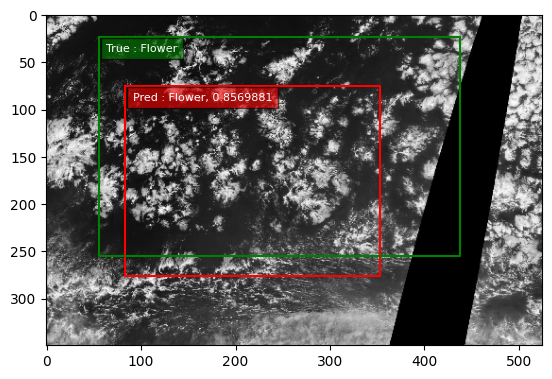

In [ ]:
sample = 11
im = load_image(df.file_name[sample])
y = df[['xmoy', 'ymoy', 'width', 'height', 'Fish', 'Flower', 'Gravel', 'Sugar']].values[sample]

print_class(im, model_class, y)

show_class_box_pred(im, model_reg, model_class, y)

In [ ]:
def show_bounding_box_sansShow(plt, im, bbox, normalised=True, color='r', text = None):
    # Signification de bbox
    x, y, w, h = bbox
    # Convertir les cordonées (x,y,w,h) en (x1,x2,y1,y2)
    x1=x-w/2
    x2=x+w/2
    y1=y-h/2
    y2=y+h/2

    # Redimensionner en cas de normalisation
    if normalised:
        x1=x1*im.shape[1]
        x2=x2*im.shape[1]
        y1=y1*im.shape[0]
        y2=y2*im.shape[0]

    # Afficher l'image
    plt.text(x1+8, y1+16, text, color='white', fontsize=8, bbox=dict(facecolor=color, alpha=0.6))

    # Afficher la bounding box
    plt.plot([x1,x2,x2,x1,x1],[y1,y1,y2,y2,y1],color)
    #return plt

def save_class_box_pred(plt, img, model_box, model_class, y_true, save_path):
  classes = ['Fish', 'Flower', 'Gravel', 'Sugar']
  real_class = classes[np.argmax([y_true[4], y_true[5], y_true[6], y_true[7]])]
  fish, flower, gravel, sugar = model_class.predict(np.array([img], dtype=np.float32))[0]
  probs = [fish, flower, gravel, sugar]
  pred_class = classes[np.argmax([probs])]
  plt.imshow(img)  # Afficher l'image sur les sous-graphiques
  x, y, w, h = model_box.predict(np.array([img], dtype=np.float32))[0]
  show_bounding_box_sansShow(plt, img/255, [x,y,w,h], text = 'Pred : '+ pred_class+ ', '+ str(max(probs)))
  show_bounding_box_sansShow(plt, img/255, [y_true[0], y_true[1], y_true[2], y_true[3]], color = 'g', text = 'True : ' +real_class)
  if save_path:
    plt.savefig(save_path)
    print("Image saved at", save_path)

In [ ]:
n = df.shape[0]
folder_pred_images = '/content/drive/MyDrive/Partage Full CloudiAtlas/Outputs/pred_images_mono/'

for i in range(n):
  fig = plt.figure()
  print(df.file_name[i])
  save_path = folder_pred_images + df.file_name[i]
  img = load_image(df.file_name[i])
  y_true = df[['xmoy', 'ymoy', 'width', 'height', 'Fish', 'Flower', 'Gravel', 'Sugar']].values[i]

  classes = ['Fish', 'Flower', 'Gravel', 'Sugar']
  real_class = classes[np.argmax([y_true[4], y_true[5], y_true[6], y_true[7]])]
  fish, flower, gravel, sugar = model_class.predict(np.array([img], dtype=np.float32))[0]
  probs = [fish, flower, gravel, sugar]
  pred_class = classes[np.argmax([probs])]
  plt.imshow(img/255, cmap='gray')  # Afficher l'image sur les sous-graphiques
  x, y, w, h = model_reg.predict(np.array([img], dtype=np.float32))[0]
  print(x, y, w, h)
  normalised=True
  text = 'Pred : '+ pred_class+ ', '+ str(max(probs))
  color = 'r'
  # Convertir les cordonées (x,y,w,h) en (x1,x2,y1,y2)
  x1=x-w/2
  x2=x+w/2
  y1=y-h/2
  y2=y+h/2
  if normalised:
    x1=x1*img.shape[1]
    x2=x2*img.shape[1]
    y1=y1*img.shape[0]
    y2=y2*img.shape[0]
  # Afficher l'image
  plt.text(x1+8, y1+16, text, color='white', fontsize=8, bbox=dict(facecolor=color, alpha=0.6))
  # Afficher la bounding box
  plt.plot([x1,x2,x2,x1,x1],[y1,y1,y2,y2,y1],color)

  bbox = [y_true[0], y_true[1], y_true[2], y_true[3]]
  color = 'g'
  text = 'True : ' +real_class
  x, y, w, h = bbox
  # Convertir les cordonées (x,y,w,h) en (x1,x2,y1,y2)
  x1=x-w/2
  x2=x+w/2
  y1=y-h/2
  y2=y+h/2
  if normalised:
    x1=x1*img.shape[1]
    x2=x2*img.shape[1]
    y1=y1*img.shape[0]
    y2=y2*img.shape[0]
  # Afficher l'image
  plt.text(x1+8, y1+16, text, color='white', fontsize=8, bbox=dict(facecolor=color, alpha=0.6))
  # Afficher la bounding box
  plt.plot([x1,x2,x2,x1,x1],[y1,y1,y2,y2,y1],color)
  if save_path:
    plt.savefig(save_path)
    print("Image saved at", save_path)
  plt.clf()

008233e.jpg
1/1 [==============================] - 0s 78ms/step
0.43480328 0.44254974 0.5824875 0.60949063
Image saved at /content/drive/MyDrive/Partage Full CloudiAtlas/Outputs/pred_images_mono/008233e.jpg
0095357.jpg
1/1 [==============================] - 0s 47ms/step
0.45364067 0.5208204 0.5410633 0.5614427
Image saved at /content/drive/MyDrive/Partage Full CloudiAtlas/Outputs/pred_images_mono/0095357.jpg
00d4443.jpg
1/1 [==============================] - 0s 114ms/step
0.4014538 0.5366633 0.52097017 0.5598578
Image saved at /content/drive/MyDrive/Partage Full CloudiAtlas/Outputs/pred_images_mono/00d4443.jpg
0146ef3.jpg
1/1 [==============================] - 0s 56ms/step
0.46965447 0.43288115 0.6280714 0.69052404
Image saved at /content/drive/MyDrive/Partage Full CloudiAtlas/Outputs/pred_images_mono/0146ef3.jpg
01c6ec3.jpg
1/1 [==============================] - 0s 58ms/step
0.4317357 0.48578298 0.53274685 0.58735853
Image saved at /content/drive/MyDrive/Partage Full CloudiAtlas/Outpu

<ipython-input-34-e28983b2a6c1>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


Image saved at /content/drive/MyDrive/Partage Full CloudiAtlas/Outputs/pred_images_mono/08f8fe9.jpg
0929f85.jpg
1/1 [==============================] - 0s 26ms/step
0.40110722 0.48765597 0.5205893 0.5667201
Image saved at /content/drive/MyDrive/Partage Full CloudiAtlas/Outputs/pred_images_mono/0929f85.jpg
094e354.jpg
1/1 [==============================] - 0s 27ms/step
0.38904282 0.49639428 0.51099366 0.53589535
Image saved at /content/drive/MyDrive/Partage Full CloudiAtlas/Outputs/pred_images_mono/094e354.jpg
09d0eee.jpg
1/1 [==============================] - 0s 28ms/step
0.46384504 0.55807996 0.5795111 0.6073496
Image saved at /content/drive/MyDrive/Partage Full CloudiAtlas/Outputs/pred_images_mono/09d0eee.jpg
0a380d0.jpg
1/1 [==============================] - 0s 39ms/step
0.4367334 0.5553446 0.5097859 0.5220312
Image saved at /content/drive/MyDrive/Partage Full CloudiAtlas/Outputs/pred_images_mono/0a380d0.jpg
0a914ab.jpg
1/1 [==============================] - 0s 39ms/step
0.41539907 0

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

def intersect(x1, y1, w1, h1, x2, y2, w2, h2):
  xa1 = x1-w1/2
  xb1 = x1+w1/2
  ya1 = y1-h1/2
  yb1 = y1+h1/2
  xa2 = x2-w2/2
  xb2 = x2+w2/2
  ya2 = y2-h2/2
  yb2 = y2+h2/2
  print(xa1, xb1, ya1, yb1)
  print(xa2, xb2, ya2, yb2)
  plt.plot([xa1,xb1,xb1,xa1,xa1],[ya1,ya1,yb1,yb1,ya1],"b", alpha = 0.5)
  plt.plot([xa2,xb2,xb2,xa2,xa2],[ya2,ya2,yb2,yb2,ya2],"g", alpha = 0.5)
  if (x1-w1/2 <= x2-w2/2 and x1+w1/2 < x2-w2/2) or (x1-w1/2 > x2-w2/2 and x2+w2/2 < x1-w1/2) or (y1-h1/2 <= y2-h2/2 and y1+h1/2 < y2-h2/2) or (y1-h1/2 > y2-h2/2 and y2+h2/2 < y1-h1/2):
    return 0, 0, 0, 0
  else:
    xa = max(xa1, xa2)
    xb = min(xb1, xb2)
    ya = max(ya1, ya2)
    yb = min(yb1, yb2)
    plt.plot([xa,xb,xb,xa,xa],[ya,ya,yb,yb,ya],"r", alpha = 0.5)
    x = (xa+xb)/2
    y = (ya+yb)/2
    w = (xb-xa)
    h = (yb-ya)
    return x, y, w, h


9.0 13.0 4.0 6.0
0.0 10.0 4.0 6.0
(9.5, 5.0, 1.0, 2.0)


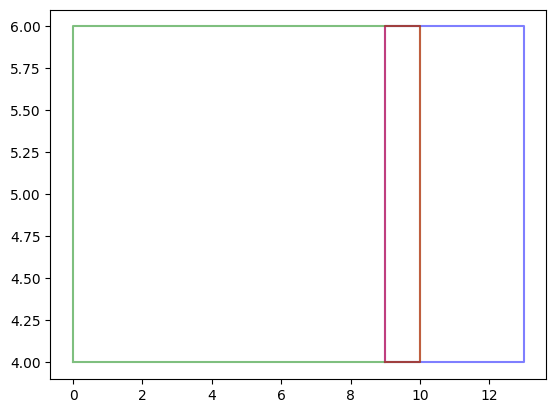

In [ ]:
print(intersect(11, 5, 4, 2, 5, 5, 10, 2))

0.5420487663376375 0.5903264304573744 0.09966976217130624 0.7205210085539868
-0.1005306408703483 0.8923527520753072 -0.2885096076247391 0.34244275199875496
(0.566187598397506, 0.2210562570850306, 0.048277664119736885, 0.24277298982744872)


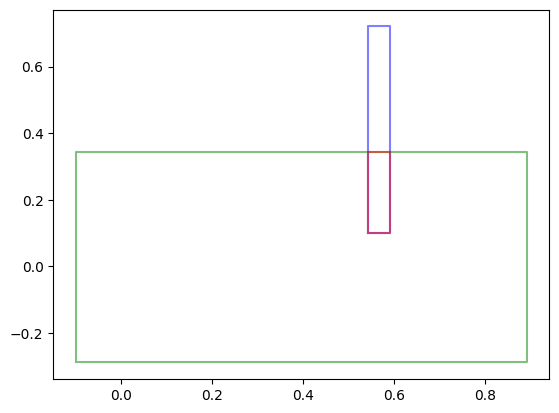

In [ ]:
import random

print(intersect(random.random(), random.random(), random.random(), random.random(), random.random(), random.random(), random.random(), random.random()))